In [1]:
# 1. BASIC SETUP & DATA LOADING
import pandas as pd
import numpy as np
import os
train_path = "/content/train.csv"
test_path  = "/content/test.csv"
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
train_df.head()


Train shape: (16209, 21)
Test shape : (5404, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [2]:
train_df.columns


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [3]:
# Image directories
TRAIN_IMAGE_DIR = "/content/drive/MyDrive/images_cdc"
TEST_IMAGE_DIR  = "/content/drive/MyDrive/images_cdc_test"
print("Train images:", len(os.listdir(TRAIN_IMAGE_DIR)))
print("Test images :", len(os.listdir(TEST_IMAGE_DIR)))


Train images: 16109
Test images : 5396


In [4]:
# Look at a few training image names
os.listdir(TRAIN_IMAGE_DIR)[:10]


['8562600500.tif',
 '2738640310.tif',
 '9285800735.tif',
 '5318101185.tif',
 '5101404351.tif',
 '1085622460.tif',
 '1254200015.tif',
 '3023049236.tif',
 '224069010.tif',
 '1245001763.tif']

In [5]:
# Look at a few test image names
os.listdir(TEST_IMAGE_DIR)[:10]


['7784400130.tif',
 '7941140070.tif',
 '2122049096.tif',
 '6003000851.tif',
 '7203220050.tif',
 '8898700960.tif',
 '5245600105.tif',
 '3530470190.tif',
 '7883603965.tif',
 '4022902505.tif']

In [6]:
# 2. ATTACH IMAGE PATHS TO ROWS
train_df['id'] = train_df['id'].astype(str)
test_df['id']  = test_df['id'].astype(str)
train_df['image_path'] = train_df['id'] + ".tif"
train_df['image_path'] = train_df['image_path'].apply(
    lambda x: os.path.join(TRAIN_IMAGE_DIR, x)
)

test_df['image_path'] = test_df['id'] + ".tif"
test_df['image_path'] = test_df['image_path'].apply(
    lambda x: os.path.join(TEST_IMAGE_DIR, x)
)

train_df[['id', 'image_path']].head()


,id,image_path
0,9117000170,/content/drive/MyDrive/images_cdc/9117000170.tif
1,6700390210,/content/drive/MyDrive/images_cdc/6700390210.tif
2,7212660540,/content/drive/MyDrive/images_cdc/7212660540.tif
3,8562780200,/content/drive/MyDrive/images_cdc/8562780200.tif
4,7760400350,/content/drive/MyDrive/images_cdc/7760400350.tif


In [7]:
# 3. IMAGE INTEGRITY CHECK
missing_train = train_df[~train_df['image_path'].apply(os.path.exists)]
missing_test  = test_df[~test_df['image_path'].apply(os.path.exists)]
print("Missing train images:", len(missing_train))
print("Missing test images :", len(missing_test))


Missing train images: 1
Missing test images : 0


In [8]:
# 4. REMOVE ROWS WITH MISSING IMAGES
bad_rows = train_df[~train_df['image_path'].apply(os.path.exists)]
print("Bad row IDs:")
print(bad_rows['id'].values)
train_df = train_df[train_df['image_path'].apply(os.path.exists)].reset_index(drop=True)
print("New train shape:", train_df.shape)


Bad row IDs:
['1861100267']
New train shape: (16208, 22)


In [9]:
print("Missing train images:",
      (~train_df['image_path'].apply(os.path.exists)).sum())


Missing train images: 0


In [10]:
# 5. TABULAR-ONLY BASELINE MODEL
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
X = train_df.drop(columns=["price", "id", "image_path", "date"])
y = train_df["price"]
y_log = np.log1p(y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
baseline_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
# Train
baseline_model.fit(X_train, y_train)
# Predict
y_val_pred_log = baseline_model.predict(X_val)
# Inverse log-transform
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val)
# Metrics (sklearn-version safe)
rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
r2 = r2_score(y_val_true, y_val_pred)
print(f"Baseline RMSE: {rmse:,.0f}")
print(f"Baseline R²  : {r2:.4f}")




Baseline RMSE: 109,037
Baseline R²  : 0.8973


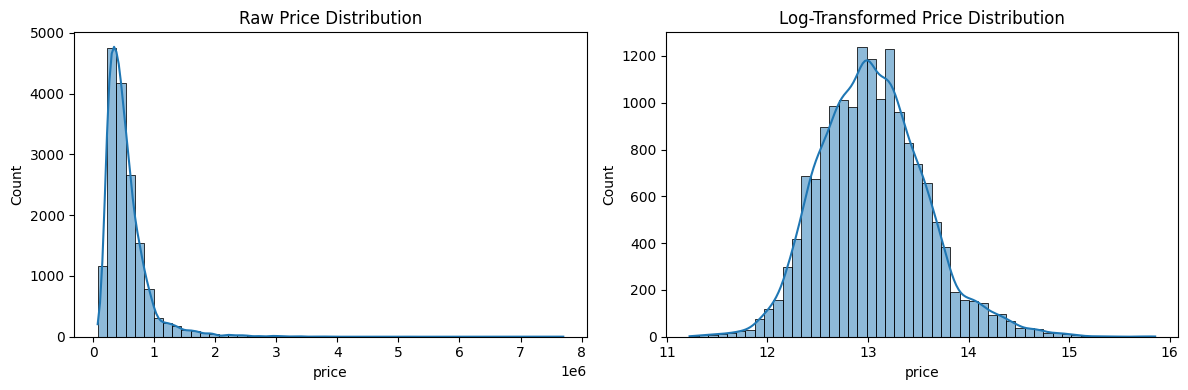

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(train_df["price"], bins=50, kde=True)
plt.title("Raw Price Distribution")
plt.subplot(1,2,2)
sns.histplot(np.log1p(train_df["price"]), bins=50, kde=True)
plt.title("Log-Transformed Price Distribution")
plt.tight_layout()
plt.show()


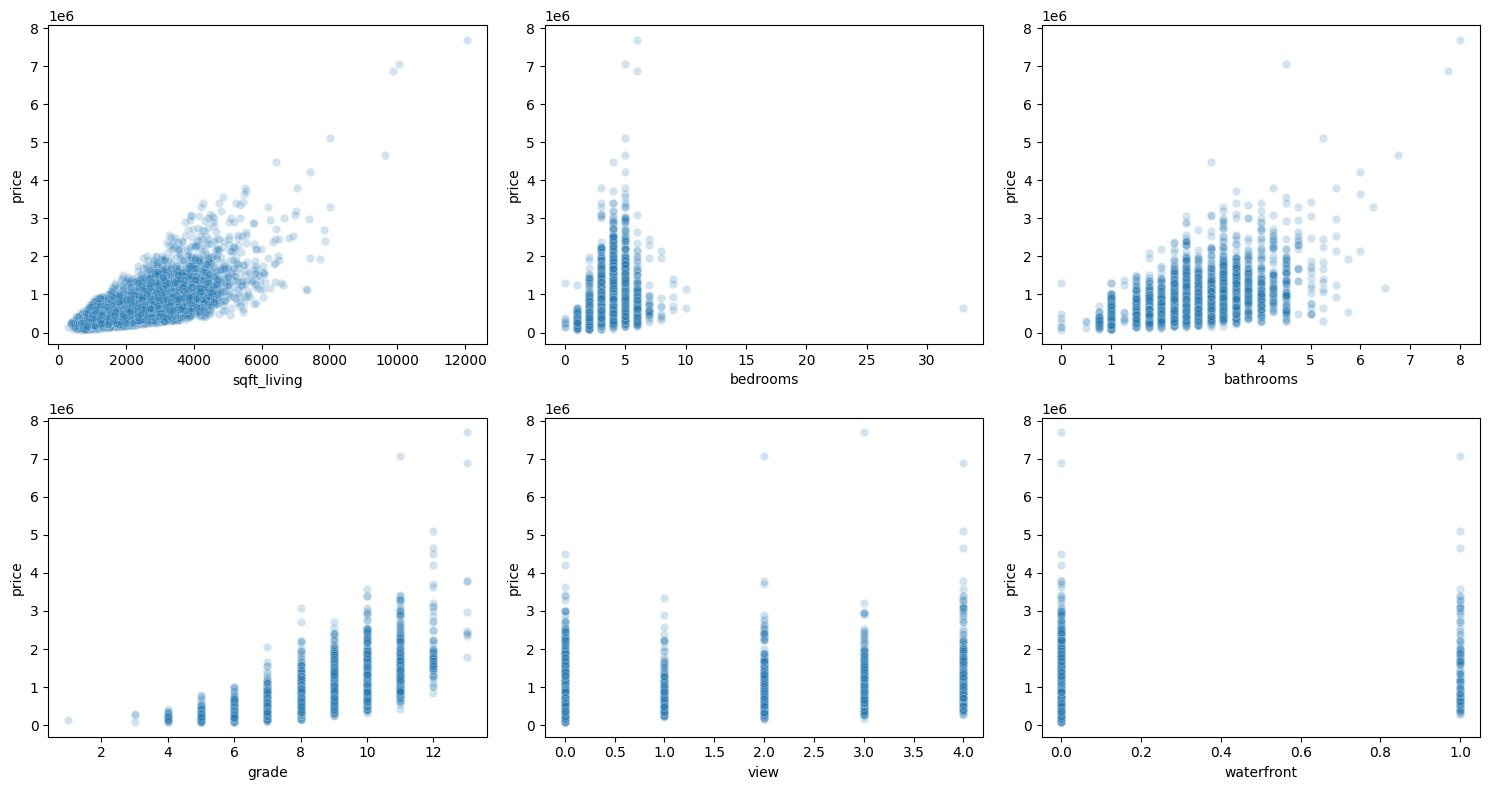

In [17]:
key_features = [
    "sqft_living",
    "bedrooms",
    "bathrooms",
    "grade",
    "view",
    "waterfront"
]
plt.figure(figsize=(15,8))
for i, col in enumerate(key_features):
    plt.subplot(2,3,i+1)
    sns.scatterplot(
        x=train_df[col],
        y=train_df["price"],
        alpha=0.2
    )
    plt.xlabel(col)
    plt.ylabel("price")
plt.tight_layout()
plt.show()


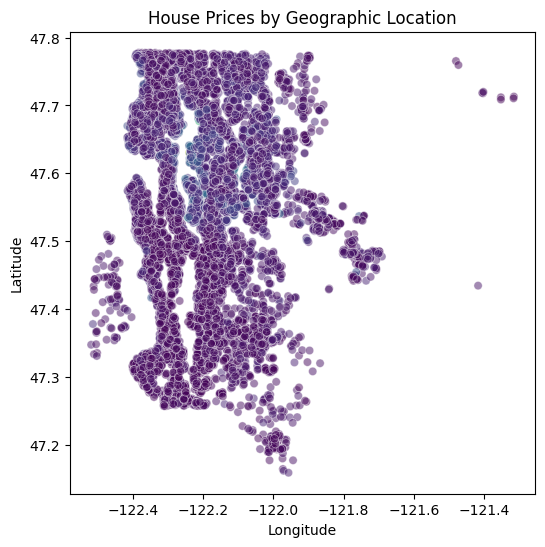

In [13]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=train_df["long"],
    y=train_df["lat"],
    hue=train_df["price"],
    palette="viridis",
    alpha=0.5,
    legend=False
)
plt.title("House Prices by Geographic Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


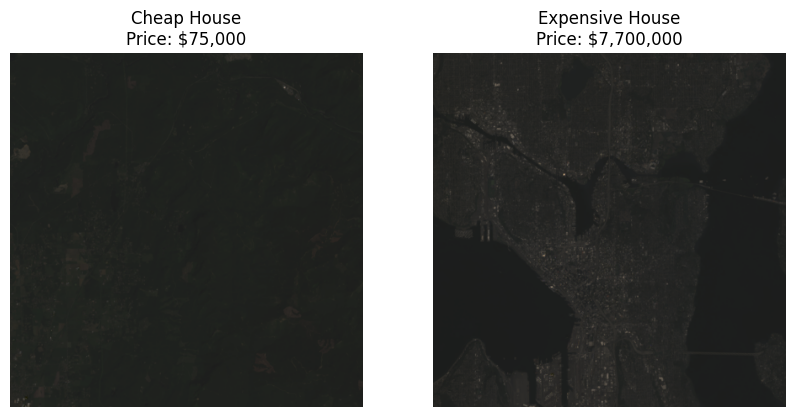

In [18]:
from PIL import Image
# Sample cheap and expensive houses
cheap = train_df.sort_values("price").iloc[0]
expensive = train_df.sort_values("price").iloc[-1]
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(Image.open(cheap["image_path"]))
ax[0].set_title(f"Cheap House\nPrice: ${cheap['price']:,}")
ax[0].axis("off")
ax[1].imshow(Image.open(expensive["image_path"]))
ax[1].set_title(f"Expensive House\nPrice: ${expensive['price']:,}")
ax[1].axis("off")
plt.show()


In [19]:

# 6. IMAGE PREPROCESSING SETUP
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
# ImageNet normalization (important for pretrained CNNs)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [20]:

# 7. CUSTOM IMAGE DATASET
class HouseImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


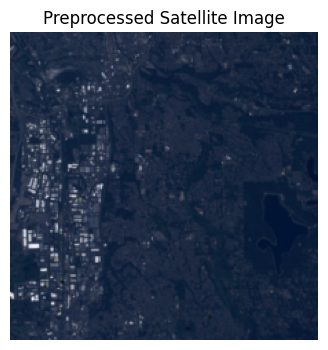

In [21]:
# Create dataset
image_dataset = HouseImageDataset(train_df, transform=image_transforms)
# Take one sample
sample_img = image_dataset[0]
# Convert back for display
img_np = sample_img.permute(1, 2, 0).numpy()
plt.figure(figsize=(4,4))
plt.imshow((img_np - img_np.min()) / (img_np.max() - img_np.min()))
plt.axis("off")
plt.title("Preprocessed Satellite Image")
plt.show()


In [22]:
# 8. LOAD PRETRAINED CNN
import torchvision.models as models
import torch.nn as nn
# Load pretrained ResNet50
resnet = models.resnet50(pretrained=True)
# Remove final classification layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Freeze all CNN weights
for param in resnet.parameters():
    param.requires_grad = False
# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
resnet.eval()
print("CNN loaded and frozen.")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


CNN loaded and frozen.


In [23]:
# 9. IMAGE DATALOADER
from torch.utils.data import DataLoader
BATCH_SIZE = 32
image_dataset = HouseImageDataset(
    train_df,
    transform=image_transforms
)

image_loader = DataLoader(
    image_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("DataLoader ready.")


DataLoader ready.


In [24]:
# 10. EXTRACT VISUAL EMBEDDINGS
import numpy as np
from tqdm import tqdm
all_embeddings = []
with torch.no_grad():
    for images in tqdm(image_loader):
        images = images.to(device)
        # Forward pass
        features = resnet(images)
        # Flatten (B, 2048, 1, 1) -> (B, 2048)
        features = features.view(features.size(0), -1)
        all_embeddings.append(features.cpu().numpy())
# Stack all batches
image_embeddings = np.vstack(all_embeddings)
print("Image embeddings shape:", image_embeddings.shape)


100%|██████████| 507/507 [1:00:42<00:00,  7.18s/it]

Image embeddings shape: (16208, 2048)


In [25]:
''' 11. MERGE EMBEDDINGS WITH TABULAR DATA
 Convert embeddings to DataFrame'''
emb_df = pd.DataFrame(
    image_embeddings,
    columns=[f"img_feat_{i}" for i in range(image_embeddings.shape[1])]
)

# Reset index to ensure alignment
train_df = train_df.reset_index(drop=True)
emb_df = emb_df.reset_index(drop=True)

# Concatenate
train_df = pd.concat([train_df, emb_df], axis=1)

print("Final train_df shape:", train_df.shape)


Final train_df shape: (16208, 2070)


In [26]:
train_df.filter(like="img_feat_").iloc[0].head()


,0
img_feat_0,0.140677
img_feat_1,0.500674
img_feat_2,0.013485
img_feat_3,0.109023
img_feat_4,0.000000


In [27]:
# 12. MULTIMODAL FEATURE MATRIX
# Separate tabular features (same as baseline)
X_tab = train_df.drop(
    columns=["price", "id", "image_path", "date"] +
            [c for c in train_df.columns if c.startswith("img_feat_")]
)
# Extract image features
X_img = train_df.filter(like="img_feat_")
# Combine
X_multi = np.hstack([X_tab.values, X_img.values])
y = train_df["price"]
y_log = np.log1p(y)
print("Tabular shape :", X_tab.shape)
print("Image shape   :", X_img.shape)
print("Multimodal X :", X_multi.shape)


Tabular shape : (16208, 18)
Image shape   : (16208, 2048)
Multimodal X : (16208, 2066)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_multi, y_log, test_size=0.2, random_state=42
)


In [29]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

multi_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

multi_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [30]:
# Predict (log scale)
y_val_pred_log = multi_model.predict(X_val)

# Back to price scale
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val)

rmse_multi = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
r2_multi = r2_score(y_val_true, y_val_pred)

print(f"Multimodal RMSE: {rmse_multi:,.0f}")
print(f"Multimodal R²  : {r2_multi:.4f}")


Multimodal RMSE: 116,346
Multimodal R²  : 0.8831


In [31]:
# 13. IMAGE FEATURE MATRIX
X_img = train_df.filter(like="img_feat_").values
print("Original image feature shape:", X_img.shape)


Original image feature shape: (16208, 2048)


In [32]:
# 14. PCA DIMENSIONALITY REDUCTION
from sklearn.decomposition import PCA

pca = PCA(
    n_components=50,
    random_state=42
)

X_img_pca = pca.fit_transform(X_img)

print("Reduced image feature shape:", X_img_pca.shape)
print("Explained variance (sum):", pca.explained_variance_ratio_.sum())


Reduced image feature shape: (16208, 50)
Explained variance (sum): 0.8842982


In [33]:
# 15. PCA MULTIMODAL FEATURE MATRIX
# Tabular features (same as baseline)
X_tab = train_df.drop(
    columns=["price", "id", "image_path", "date"] +
            [c for c in train_df.columns if c.startswith("img_feat_")]
).values

# Combine
X_multi_pca = np.hstack([X_tab, X_img_pca])

y = train_df["price"]
y_log = np.log1p(y)

print("Tabular shape:", X_tab.shape)
print("PCA image shape:", X_img_pca.shape)
print("Multimodal PCA shape:", X_multi_pca.shape)


Tabular shape: (16208, 18)
PCA image shape: (16208, 50)
Multimodal PCA shape: (16208, 68)


In [34]:

# 16. PCA MULTIMODAL MODEL

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X_multi_pca, y_log, test_size=0.2, random_state=42
)

# Model
pca_multi_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train
pca_multi_model.fit(X_train, y_train)

# Predict
y_val_pred_log = pca_multi_model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val)

# Metrics
rmse_pca = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
r2_pca = r2_score(y_val_true, y_val_pred)

print(f"PCA Multimodal RMSE: {rmse_pca:,.0f}")
print(f"PCA Multimodal R²  : {r2_pca:.4f}")


PCA Multimodal RMSE: 109,507
PCA Multimodal R²  : 0.8964


In [35]:

# FINAL TABULAR MODEL (FULL DATA)


from xgboost import XGBRegressor
import numpy as np

# Prepare full training data
X_full = train_df.drop(columns=["price", "id", "image_path", "date"])
y_full = np.log1p(train_df["price"])

# Final model (same hyperparameters as baseline)
final_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_full, y_full)

print("Final model trained on full data.")


Final model trained on full data.


In [36]:
# Define PURE tabular columns explicitly
TABULAR_COLS = [
    c for c in train_df.columns
    if c not in ["price", "id", "image_path", "date"]
    and not c.startswith("img_feat_")
]

print("Number of tabular features:", len(TABULAR_COLS))



Number of tabular features: 18


In [37]:

# FINAL TABULAR MODEL


from xgboost import XGBRegressor
import numpy as np

# Training data
X_full = train_df[TABULAR_COLS]
y_full = np.log1p(train_df["price"])

# Final model (same hyperparameters as baseline)
final_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train on ALL data
final_model.fit(X_full, y_full)

print("✅ Final tabular model trained successfully.")


✅ Final tabular model trained successfully.


In [40]:

# BUILD TEST FEATURES (SAFE)

X_test = test_df[TABULAR_COLS]

print("Train feature shape:", X_full.shape)
print("Test feature shape :", X_test.shape)


Train feature shape: (16208, 18)
Test feature shape : (5404, 18)


In [41]:

# TEST SET PREDICTIONS


# Predict (log scale)
test_pred_log = final_model.predict(X_test)

# Convert back to original price scale
test_pred_price = np.expm1(test_pred_log)

# Create submission DataFrame
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": test_pred_price
})

submission_df.head()


,id,predicted_price
0,2591820310,3.754911e+05
1,7974200820,8.346281e+05
2,7701450110,1.107788e+06
3,9522300010,1.680203e+06
4,9510861140,7.277936e+05


In [42]:

# SAVE SUBMISSION FILE


submission_df.to_csv("predicted_prices.csv", index=False)
print("✅ predicted_prices.csv saved successfully.")


✅ predicted_prices.csv saved successfully.


In [ ]:
# GRAD-CAM SETUP
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load pretrained ResNet50
resnet = models.resnet50(pretrained=True)
# Remove classifier head (same as feature extraction)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet = resnet.to(device)
resnet.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:

# GRAD-CAM CLASS


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        output = self.model(input_tensor)
        score = output.mean()          # scalar target
        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        cam = cam[0].cpu().detach().numpy()
        cam = cv2.resize(cam, (224,224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


In [ ]:
from torchvision import transforms

image_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
target_layer = resnet[-1]
gradcam = GradCAM(resnet, target_layer)


In [ ]:

# SELECT SAMPLE HOUSES


cheap_house = train_df.sort_values("price").iloc[0]
mid_house   = train_df.sort_values("price").iloc[len(train_df)//2]
rich_house  = train_df.sort_values("price").iloc[-1]

samples = [
    ("Cheap", cheap_house),
    ("Mid", mid_house),
    ("Expensive", rich_house)
]


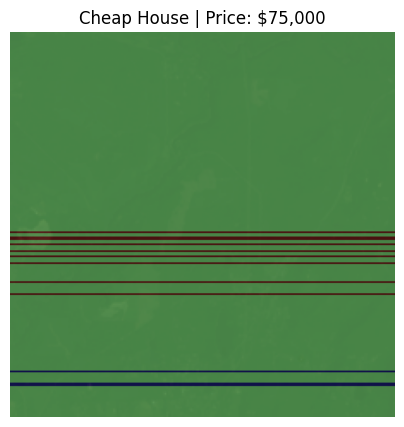

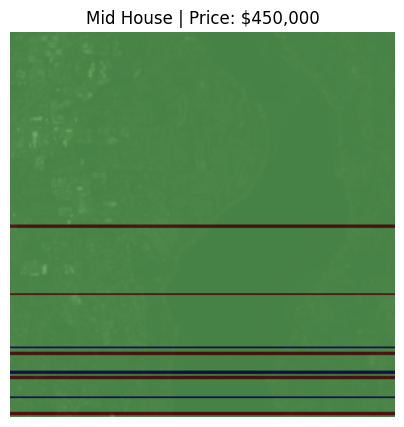

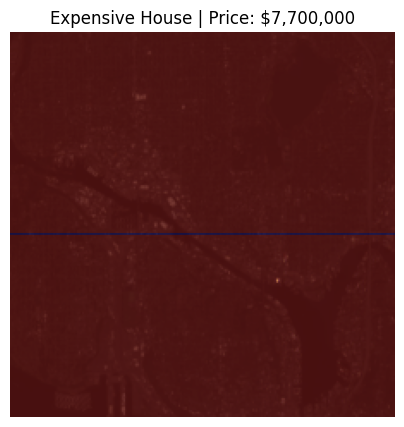

In [ ]:

# GRAD-CAM VISUALIZATION


for label, row in samples:
    img = Image.open(row["image_path"]).convert("RGB")
    img_tensor = image_transforms(img).unsqueeze(0).to(device)

    cam = gradcam.generate(img_tensor)

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.imshow(cam, cmap="jet", alpha=0.45)
    plt.axis("off")
    plt.title(f"{label} House | Price: ${row['price']:,}")
    plt.show()


In [ ]:
from torchvision import models

resnet_full = models.resnet50(pretrained=True)
resnet_full = resnet_full.to(device)
resnet_full.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
target_layer = resnet_full.layer4[-1]


In [ ]:
def generate(self, input_tensor):
    output = self.model(input_tensor)

    # Use the L2 norm of features as scalar target
    score = output.norm()
    self.model.zero_grad()
    score.backward()

    weights = self.gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * self.activations).sum(dim=1)
    cam = F.relu(cam)

    cam = cam[0].cpu().detach().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam


In [ ]:
gradcam = GradCAM(resnet_full, target_layer)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


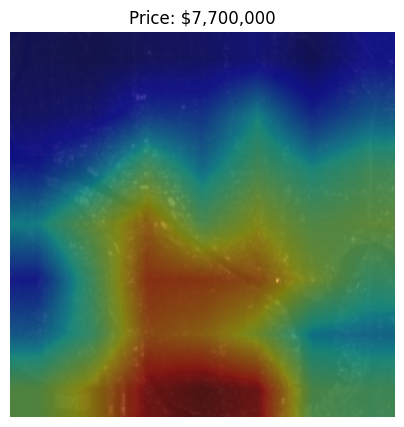

In [ ]:
img = Image.open(row["image_path"]).convert("RGB")
img_tensor = image_transforms(img).unsqueeze(0).to(device)

cam = gradcam.generate(img_tensor)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=0.45)
plt.axis("off")
plt.title(f"Price: ${row['price']:,}")
plt.show()


In [ ]:

# SHAP EXPLAINABILITY


import shap

# Use TreeExplainer (fast & exact for XGBoost)
explainer = shap.TreeExplainer(final_model)

# Take a sample (SHAP is expensive)
X_sample = X_full.sample(500, random_state=42)

shap_values = explainer.shap_values(X_sample)


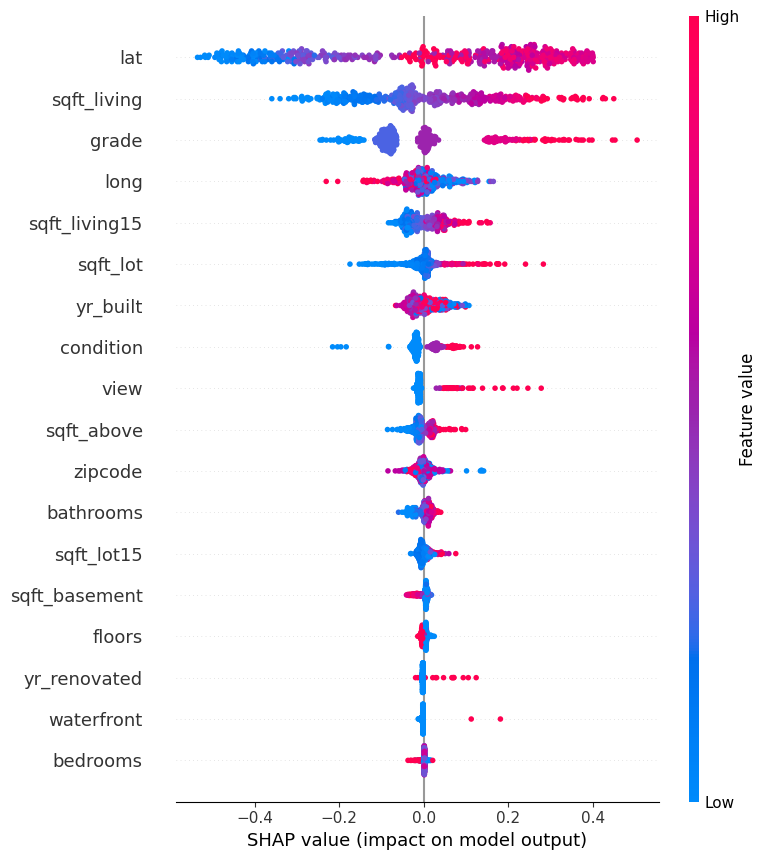

In [ ]:
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=TABULAR_COLS
)


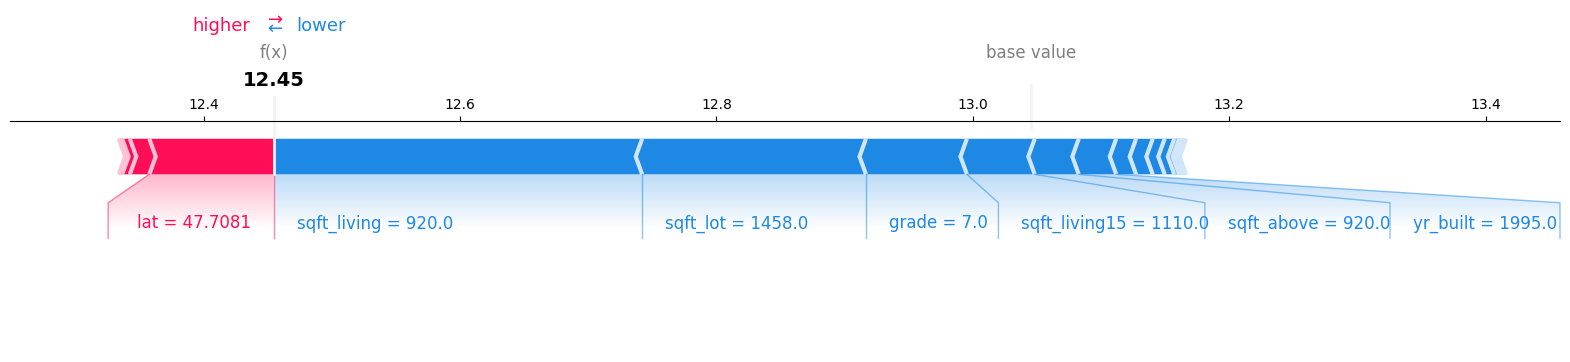

In [ ]:
# Pick one house
idx = 100
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_sample.iloc[idx],
    matplotlib=True
)


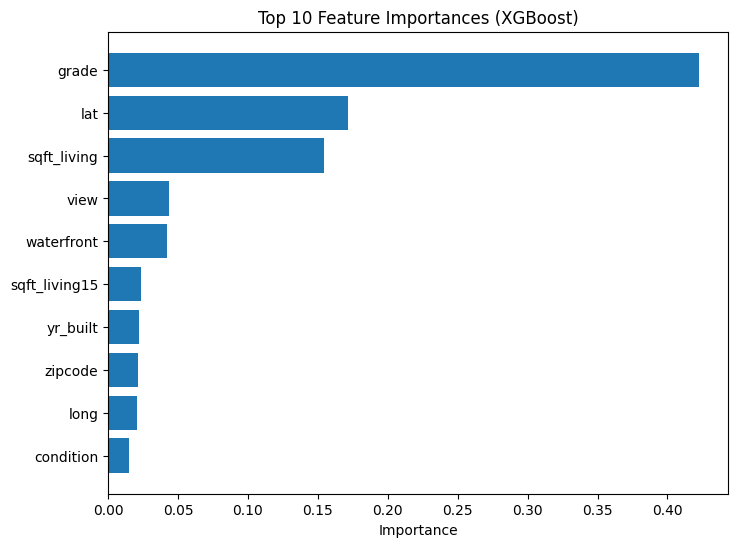

In [ ]:

# XGBOOST FEATURE IMPORTANCE

import pandas as pd
import matplotlib.pyplot as plt

importance = final_model.feature_importances_

imp_df = pd.DataFrame({
    "feature": TABULAR_COLS,
    "importance": importance
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(imp_df["feature"][:10], imp_df["importance"][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()


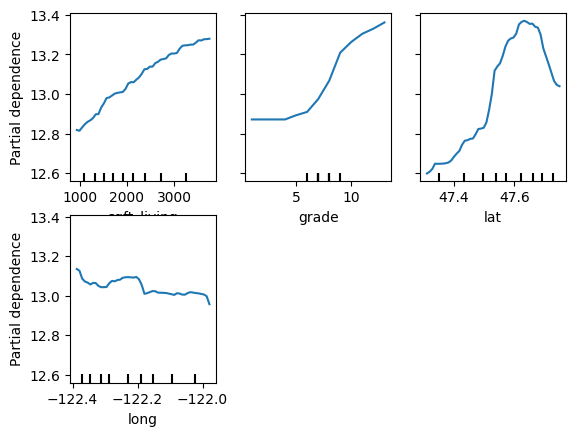

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ["sqft_living", "grade", "lat", "long"]

PartialDependenceDisplay.from_estimator(
    final_model,
    X_full,
    features_to_plot,
    grid_resolution=50
)

plt.show()



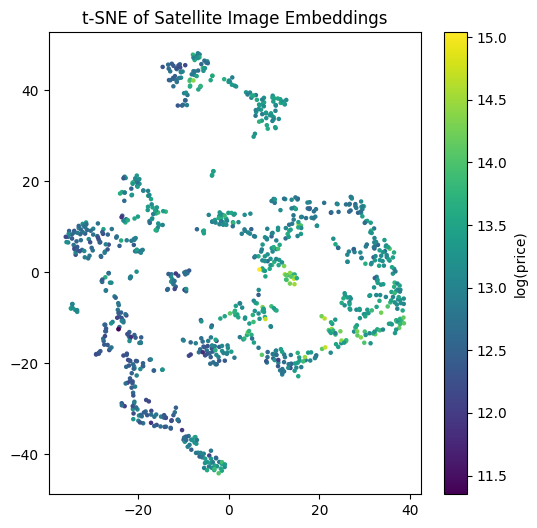

In [ ]:
from sklearn.manifold import TSNE

# Use PCA-reduced image features
X_img_vis = X_img_pca[:1000]
y_vis = train_df["price"].iloc[:1000]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_img_vis)

plt.figure(figsize=(6,6))
plt.scatter(
    X_tsne[:,0],
    X_tsne[:,1],
    c=np.log1p(y_vis),
    cmap="viridis",
    s=5
)
plt.colorbar(label="log(price)")
plt.title("t-SNE of Satellite Image Embeddings")
plt.show()
